# Libraries

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import time

start_time = time.time()  # Start time

# Data

In [53]:
# key variable for how quick the notebook is running. Choose 0.001 or less for 1-3 minutes
subset_fraction=0.001

# load your dataset
df_train = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_train.parquet')  # load your training data
df_test = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_test.parquet')    # load your test data

# randomly select % of the training and test data (for exploration)
df_train_sampled = df_train.sample(frac=subset_fraction, random_state=1984)          # % of train data
df_test_sampled = df_test.sample(frac=subset_fraction, random_state=1984)            # % of test data

# define training and testing features and labels
X_train = df_train_sampled.drop(columns=['label', 'class_label', 'category_label', 'attack_label'])
y_train = df_train_sampled['attack_label']
X_test = df_test_sampled.drop(columns=['label', 'class_label', 'category_label', 'attack_label'])
y_test = df_test_sampled['attack_label']

# GA

This function evaluates the fitness of an individual (a potential solution) in a genetic algorithm by selecting features based on the individual's genes. Here’s what happens:

__Feature Selection__: The individual's genes (binary values) determine which features to select for training. If a gene is greater than 0.5, the corresponding feature is selected.

__Empty Set Check__: If no features are selected, the function returns a fitness score of 0 to avoid training on an empty feature set.

__Model Training__: A Random Forest classifier is trained on the selected features using the training dataset.

__Prediction__: The trained model predicts labels for the test dataset using the same selected features.

__Fitness Calculation__: The accuracy of the predictions is calculated, which serves as the fitness score of the individual. This score represents how well the selected feature subset performs in classification.

The higher the accuracy, the better the individual's solution.

In [54]:
# define the fitness function for evaluating feature subsets
def evaluate_feature_selection(individual):
    # function selects the features based on the individual's genes - features with values > 0.5 are selected
    selected_features = np.where(individual > 0.5)[0]        # select features based on individual genes
    if len(selected_features) == 0:                          # avoid empty feature set
        return 0
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    rf = RandomForestClassifier(random_state=1984)           # create rf model
    rf.fit(X_train_selected, y_train)                        # fit the model
    y_pred = rf.predict(X_test_selected)                     # predict attack_label
    
    accuracy = accuracy_score(y_test, y_pred)                # calculate accuracy of prediction - fitness function
    return accuracy                                          # return accuracy as the fitness score

### GA Parameters

__population_size__: Defines the number of individuals in the population, each representing a potential solution. A larger population allows for broader exploration of the solution space.

__n_generations__: Sets the maximum number of iterations the algorithm can run, allowing the population to evolve over multiple generations to find an optimal solution.

__mutation_rate__: Specifies the probability that any gene within an individual will mutate, introducing variability and helping avoid local optima.

__fitnes_threshold__: Represents the target fitness level that the algorithm aims to achieve. If reached, the algorithm will terminate early.

__stagnation_limit__: Establishes how many generations can pass without any improvement in the best fitness score before the algorithm terminates. This helps prevent the algorithm from running unnecessarily if no progress is being made.

In [55]:
# Genetic Algorithm parameters
population_size = 20            # number of individuals in the population
n_generations = 50              # maximum number of generations
mutation_rate = 0.1             # probability of mutation
fitness_threshold = 1           # fitness goal (threshold for stopping)
stagnation_limit = 5            # number of generations without improvement before stopping

The code first determines the number of features in the dataset to define the length of each individual in the population. Then, it initializes a population of random individuals, where each individual is represented by a vector with values between 0 and 1, indicating potential feature subsets. Additionally, variables are set up to track the best fitness score and the corresponding individual across generations. A counter for the number of generations without improvement is also initialized, along with a variable to store the reason for the algorithm's termination.

In [56]:
# get the number of features for individual length
n_features = X_train.shape[1]   # number of features in dataset

# initialize population with random values between 0 and 1 (individuals represent feature subsets)
population = np.random.rand(population_size, n_features)

# initialize variables to track the best fitness and stagnation count
best_fitness_overall = 0
best_individual_overall = None
no_improvement_count = 0
termination_reason = None  # To store the reason for termination

The main loop of the genetic algorithm runs through each generation, evaluating feature selection, updating the population, and checking for termination conditions.

__Fitness Evaluation__:
For each individual in the population, a fitness score is calculated based on feature selection using the function evaluate_feature_selection.
The current best fitness score and the corresponding individual (feature subset) are tracked for each generation.

__Generation Statistics__:
For every generation, the algorithm prints the best fitness score achieved.

__Updating Best Individual__:
If the current generation produces a better fitness score than the overall best, it updates the best individual and resets the stagnation counter (which tracks the number of generations without improvement).
If no improvement is found, the stagnation counter increases.

__Termination Checks__:
The algorithm checks two termination conditions:
Fitness Threshold: If the best fitness score reaches or exceeds a pre-set threshold, the loop breaks, and termination is triggered.
Stagnation: If there is no improvement in fitness for a predefined number of generations, the algorithm terminates early.

__Selection__:
Using roulette wheel selection based on fitness scores, a new population is created from the current individuals. The likelihood of selection is proportional to the fitness of each individual.

__Crossover__:
Pairs of selected individuals undergo single-point crossover, combining their genes to produce offspring. Each pair of parents creates two children by swapping their genes at a random crossover point.

__Mutation__:
Each gene in the offspring has a chance of mutation, where a random bit is flipped (changing from 0 to 1 or vice versa) based on a predefined mutation rate.

__Population Update__:
The current population is replaced by the newly generated offspring, and the algorithm proceeds to the next generation.

__Termination Reason__:
If the termination criteria are met (fitness threshold or stagnation), the loop breaks early, and the reason is printed. If the loop completes all generations without early termination, the reason will be the maximum number of generations reached.
This process continues until one of the termination criteria is satisfied, determining how long the algorithm runs and what feature subset is ultimately chosen.

In [57]:
# Genetic Algorithm main loop for feature selection
for generation in range(n_generations):
    fitness_scores = np.array([evaluate_feature_selection(individual) for individual in population])
    
    # track the best fitness score in the current generation
    current_best_fitness = np.max(fitness_scores)
    current_best_individual = population[np.argmax(fitness_scores)]
    
    # count the number of selected features (those with values > 0.5)
    num_selected_features = np.sum(current_best_individual > 0.5)
    
    # print generation stats including number of selected features
    print(f"Generation {generation + 1}: Best Fitness = {current_best_fitness:.5f}, Selected Features = {num_selected_features}")
    
    # update the overall best fitness and individual if necessary
    if current_best_fitness > best_fitness_overall:
        best_fitness_overall = current_best_fitness
        best_individual_overall = current_best_individual
        no_improvement_count = 0  # reset stagnation counter if there's improvement
    else:
        no_improvement_count += 1  # increase stagnation counter if no improvement
    
    # check if the fitness threshold is reached
    if best_fitness_overall >= fitness_threshold:
        termination_reason = f"Desired fitness threshold of {fitness_threshold} reached."
        break
    
    # check if there's been no improvement for stagnation_limit generations
    if no_improvement_count >= stagnation_limit:
        termination_reason = f"No improvement for {stagnation_limit} generations."
        break
    
    # Selection: roulette wheel selection based on fitness
    probabilities = fitness_scores / np.sum(fitness_scores)
    selected_indices = np.random.choice(np.arange(population_size), size=population_size, p=probabilities)
    selected_population = population[selected_indices]

    # Crossover: single-point crossover
    offspring = []
    for i in range(0, population_size, 2):
        parent1, parent2 = selected_population[i], selected_population[i+1]
        crossover_point = np.random.randint(1, n_features-1)
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        offspring.extend([child1, child2])
    
    offspring = np.array(offspring)

    # Mutation: flip bits with a probability of mutation_rate
    for individual in offspring:
        mutation_mask = np.random.rand(n_features) < mutation_rate
        individual[mutation_mask] = 1 - individual[mutation_mask]  # flip 0 to 1 or 1 to 0

    # Replace the population with the offspring
    population = offspring

# if no termination reason set, the loop ran for the maximum number of generations
if termination_reason is None:
    termination_reason = f"Reached maximum number of generations ({n_generations})."

# print termination reason
print(f"Termination Reason: {termination_reason}")


Generation 1: Best Fitness = 0.99380, Selected Features = 27
Generation 2: Best Fitness = 0.98947, Selected Features = 18
Generation 3: Best Fitness = 0.99009, Selected Features = 25
Generation 4: Best Fitness = 0.99133, Selected Features = 19
Generation 5: Best Fitness = 0.99195, Selected Features = 22
Generation 6: Best Fitness = 0.98947, Selected Features = 28
Termination Reason: No improvement for 5 generations.


# Random Forest Classifier

In [58]:
# use the best features identified by GA overall
selected_features = np.where(best_individual_overall > 0.5)[0]
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# train the Random Forest with selected features
rf = RandomForestClassifier(random_state=1984)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)

In [59]:
# print the classification report
print(classification_report(y_test, y_pred))

# print the number of selected features
print(f"Number of selected features: {len(selected_features)}")

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# print accuracy with 5 decimal places
print(f"Accuracy: {accuracy:.5f}")

                    precision    recall  f1-score   support

      ARP_spoofing       0.00      0.00      0.00         1
            Benign       0.94      0.97      0.96        35
         DDoS_ICMP       1.00      1.00      1.00       352
          DDoS_SYN       1.00      1.00      1.00       177
          DDoS_TCP       1.00      1.00      1.00       157
          DDoS_UDP       1.00      1.00      1.00       367
DDoS_connect_flood       1.00      1.00      1.00        41
DDoS_publish_flood       1.00      0.56      0.71         9
          DoS_ICMP       1.00      0.99      1.00       120
           DoS_SYN       1.00      1.00      1.00        97
           DoS_TCP       1.00      1.00      1.00        78
           DoS_UDP       1.00      1.00      1.00       143
 DoS_connect_flood       1.00      1.00      1.00         1
 DoS_publish_flood       0.73      1.00      0.85        11
           OS_scan       1.00      0.33      0.50         3
         Port_scan       0.84      1.00

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


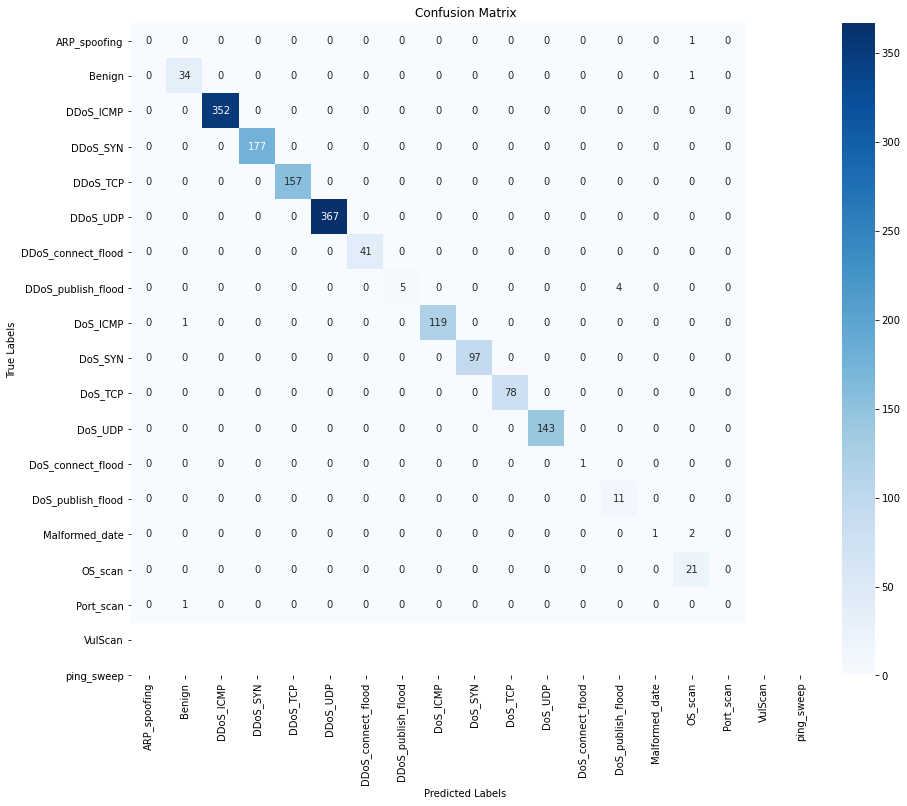

In [60]:
# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
end_time = time.time()  # End time
elapsed_time = end_time - start_time  # Calculate the total time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Total execution time: 91.98 seconds
